#  Модуль 5. NLP и LLM в финансах

# 1. Цель

В этом ноутбуке даны задания на использование современных моделей для работы с текстом. Сначала мы рассмотрим теорию решения таких задач. Ваша цель — решить задачи по подобию рассмотренных в примерах.

Каждое задание оценивается в 2 балла:

* Задание выполнено корректно — 2 балла.
* Задание выполнено частично верно — 1 балл.
* Задание выполнено неверно — 0 баллов.

Дополнительное задание  — 1 балл.

**Формат сдачи:** отправьте ссылку на измененный ноутбук (только **ссылку**, сам файл ipynb  присылать не нужно).


### **ВНИМАНИЕ!** Все ответы должны возвращаться через функции. Не удаляйте функции.



**Качество кода:** блокнот должен автоматически выполнять весь код при нажатии «Среда выполнения»/ «Выполнить все».

## Выбор уровня сложности

Запустите код в этой ячейке, чтобы выбрать один из трех уровней сложности.

Выбор уровня сложности не влияет на максимальное количество баллов, которые вы можете получить.

In [1]:
%%capture
!pip install pandas==2.0.3 gdown==4.7.3 requests==2.31.0 apimoex==1.4.0 lxml==4.9.4 ipynbname==2023.2.0.0
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gdown
import time
import json
import requests
import apimoex
import hashlib
from IPython.display import Markdown
import ipywidgets as widgets
from ipywidgets import Button
from IPython.display import display
start = time.time()

In [ ]:
import ipywidgets as widgets
student_topic_choice = 2
topics_list = ['Простое задание',
               'Стандартное задание',
               'Сложное задание']
topic_options = {topic: index + 1 for index, topic in enumerate(topics_list)}
select_widget = widgets.Dropdown(options=topic_options.keys(), value=topics_list[student_topic_choice-1], description='Выбор:')

def on_select(change):
    global student_topic_choice
    student_topic_choice = topic_options[change['new']]
    display(Markdown(f"выбран уровень сложности заданий: **{change['new']}**"))

select_widget.observe(on_select, names='value')
display(Markdown("""Мне интересно задание"""))
select_widget

Мне интересно задание

Dropdown(description='Выбор:', index=1, options=('Простое задание', 'Стандартное задание', 'Сложное задание'),…

выбран уровень сложности заданий: **Простое задание**

## Идентификация автора работы


После запуска этого кода блока вы становитесь автором данного блокнота, запрещая другим студентам пользоваться результатами своего труда, и принимаете на себя обязательства не передавать другим студентам ссылку на данный блокнот и/или файл ipynb.

В процессе выполнения кода приложение запросит доступ к данным вашего Google-аккаунта и созданию файлов. Это необходимо для создания промежуточных файлов, которые помогут подтвердить авторство работы.

Если вы не доверяете приложению, то можете завести дополнительный Google-аккаунт, на котором будут размещаться ноутбуки.

In [ ]:
import hashlib
from google.colab import auth
from google.colab import drive
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
import requests
import json
import uuid
import datetime
import ipynbname
auth.authenticate_user()
drive_service = build('drive', 'v3')                # Разрешите доступ на чтение вашего email
drive.mount('/content/drive', force_remount = True) # Разрешите доступ на запись на ваш Google Drive
nb_name = ipynbname.name()
file_id = str(uuid.uuid4())
with open("/content/"+file_id, 'w') as f:  f.write(file_id)
# Метод создает файл на Google Drive и потом его удаляет
file_metadata = {'name': 'unique_marker_'+file_id,'mimeType': 'text/plain'}
media = MediaFileUpload("/content/"+file_id,mimetype='text/plain', resumable=True)
created = drive_service.files().create(body=file_metadata,media_body=media,
                                       fields='id').execute()
response = drive_service.files().get(fileId=created.get('id'), fields='owners(emailAddress)').execute()
owner_email = response['owners'][0]['emailAddress']
response = drive_service.files().delete(fileId=created.get('id')).execute()

def get_hashed_email():
  hashed_email =hashlib.sha256(str.encode(owner_email)).hexdigest()
  return hashed_email
moment = datetime.datetime.now().isoformat()
exclusive_copyright = {
    "timestamp_remote":str(moment),
    "email_hash":str(get_hashed_email()),
    "homework_no":"4",
    "nb_name":nb_name,
    "sealed":hashlib.sha256(str.encode(owner_email+":"+moment+":"+nb_name)).hexdigest()
}
result = requests.post('https://autotest-egister.amvera.io/exclusive_copyright/', data=json.dumps(exclusive_copyright)).text

print(f"Зафиксировано авторство {result}",exclusive_copyright)

Mounted at /content/drive
Зафиксировано авторство "OK" {'timestamp_remote': '2024-05-01T10:07:16.638578', 'email_hash': 'b10ff273099d0ec13c15670e06f6d06c8ec567a1a890751a6da076b555f67022', 'homework_no': '4', 'nb_name': 'fileId=1E1BsSXY8M1bT2D5K_AMFqA4BvGRB1VTB', 'sealed': 'c39b9c38edbaf88709716ec0f5d3e6bcd4bd1ff1c470b07e86e1eac955933f63'}


# 2. Какие задачи решает NLP

Допустим, есть задача обработать[ отчет ПАО «Аэрофлот» за II квартал 2023 года](https://ir.aeroflot.ru/fileadmin/Otchet_ehmitenta_za_6_mesjacev_2023.pdf), в нем 56 страниц. Или всю ленту соцсети с хештегом #ozon. Чтобы не читать массив текста вручную, мы можем использовать методы МО, которые помогут решить эти и перечисленные ниже задачи.



### Классификация текста

Классификация текста, также известная как тегирование текста или категоризация текста, представляет собой процесс присвоения тегов или категорий текстовым данным на основе их содержимого. С помощью основ NLP текстовые классификаторы могут автоматически анализировать текстовые данные, а затем присваивать набор заранее определенных тегов или категорий. Пример – классификация электронных писем на то, является ли письмо спамом или нет, на основе их содержания.

### Анализ настроений

Одно из наиболее широко известных и реализованных применений обработки естественного языка – анализ настроений. Это вычислительный процесс для выявления эмоций и настроений, выраженных в текстовых данных разными людьми. Как правило, анализ настроений полезен для определения настроений в постах социальных сетей, продуктах, отелях и обзорах фильмов.

### Краткое содержание документа

Обобщение документов – это процесс создания краткого резюме данных с вычислительной точки зрения. Цель этого обобщения – включить в резюме наиболее важную и релевантную информацию из текстовых данных. В дополнение к тексту также могут быть обобщены изображения и видео.

### Автоматическая генерация текста

Автоматическая генерация текста – это способ прогнозирования предстоящего текста в предложениях с помощью методов обработки естественного языка и различных методов обучения, доступных в искусственном интеллекте. Некоторые известные примеры – функция автозаполнения в Gmail, поисковой системе Google, мобильных клавиатурах и т. д.

### Ответы на вопросы

Отвечающая на вопросы реализация (обычно компьютерная программа) может создавать свои ответы, запрашивая структурированную базу данных знаний или информации (обычно базу знаний). Продвинутая форма систем, отвечающих на вопросы, может извлекать ответы из неструктурированной коллекции документов на естественном языке. Эти системы также могут извлекать информацию из запросов, передаваемых пользователями.

In [2]:
!pip install pdfminer==20191125 -q
!pip install gdown -q
!pip install transformers requests -q
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
import re
import gdown
from io import StringIO
import os
import numpy as np
import pandas as pd
import nltk.tokenize
import nltk.corpus
import nltk.stem
import sklearn.decomposition
import matplotlib.pyplot as plt
import scipy.linalg
import time
import json
import requests
start = time.time()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 31.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.7 MB/s eta 0:00:00


In [3]:
def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    return text

In [4]:
url = "https://drive.google.com/uc?export=download&id=1rjR2xLhPjxjwqiJvl8jYWUfWn3yWAQLB"
output = "Otchet_ehmitenta_za_6_mesjacev_2023.pdf"
try:
  gdown.download(url, output)
except AttributeError:
  print("Используйте Яндекс диск https://disk.yandex.ru/i/ncO2lMIqkGyYqA")
  exit()

Downloading...
From: https://drive.google.com/uc?export=download&id=1rjR2xLhPjxjwqiJvl8jYWUfWn3yWAQLB
To: /content/Otchet_ehmitenta_za_6_mesjacev_2023.pdf
100%|██████████| 1.36M/1.36M [00:00<00:00, 58.7MB/s]


In [5]:
Document=convert_pdf_to_txt('Otchet_ehmitenta_za_6_mesjacev_2023.pdf')

In [6]:
with open('Otchet_ehmitenta_za_6_mesjacev_2023.txt','w') as f:
    f.write(Document)

with open('Otchet_ehmitenta_za_6_mesjacev_2023.txt','r') as f:
    clean_emitent_report = " ".join(f.read().splitlines())

In [7]:
clean_emitent_report[:150]

'   ОТЧЕТ ЭМИТЕНТА ЭМИССИОННЫХ ЦЕННЫХ БУМАГ   Публичное акционерное общество «Аэрофлот-российские авиалинии»   (полное фирменное наименование (для комм'

## 2.1. Классификация текста с помощью латентного семантического индексирования (LSI)

Рассмотрим, как задачу классификации текста решают методами классического ML — так мы сможем заглянуть под капот решения и поэтапно разобрать ход работы алгоритма.

Латентное семантическое индексирование — это упрощенный вариант анализа главных компонентов.

В основном метод предназначен для обработки естественного языка. Поскольку большинство матриц терминов документа разрежены, требование ковариационной матрицы PCA работает не очень хорошо. В LSI мы непосредственно выполняем разложение по сингулярным значениям в матрице терминов документа, а затем используем верхние $K$, соответствующие собственным векторам, для уменьшения размерности. Обычно в NLP $K$ по умолчанию равно 100, что подразумевает 100 основных разделов текстовых файлов.


In [8]:
# Преобразуем текст в список слов
# Мы можем использовать стемминг и лемматизацию для повышения эффективности
def text2list(text,stopword,lower=True,lemma=False,stemma=False):

    text_clean=text if lower==False else text.lower()

    token=[i for i in nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(text_clean) if i not in stopword]

    if lemma:
        text_processed=[nltk.stem.wordnet.WordNetLemmatizer().lemmatize(i) for i in token]
    else:
        text_processed=token

    if stemma:
        output=[nltk.stem.PorterStemmer().stem(i) for i in text_processed]
    else:
        output=text_processed

    for i in [ii for ii in output]:
        try:
            float(i)
            output.remove(i)
        except:
            pass

    return [i for i in output if i not in stopword]

In [9]:
# Создайте матрицу терминов документа с 3 различными весами
# В sklearn они следующие
# sklearn.feature_extraction.text.CountVectorizer(binary=True)
# sklearn.feature_extraction.text.TfidfVectorizer()
# sklearn.feature_extraction.text.CountVectorizer()
def create_document_term_matrix(df,vocabulary,binary=False,tfidf=False):

    document_term_matrix=np.zeros((len(vocabulary),len(df)))

    if binary:
        for i in df.index:
            for j in df['word'][i]:
                document_term_matrix[vocabulary.index(j),i]=1
    elif tfidf:
        for i in df.index:
            for j in df['word'][i]:
                tf=df['word'][i].count(j)/len(df['word'][i])
                idf_numerator=len(df)
                idf_denominator=len([ii for ii in df['word'] if j in ii])

                if idf_denominator==0:
                    idf_numerator+=1
                    idf_denominator+=1
                    tf=1/(len(df['word'][i])*2)

                idf=np.log(idf_numerator/idf_denominator)
                document_term_matrix[vocabulary.index(j),i]=tf*idf

    # Используем частоту использования термина по умолчанию
    else:
        for i in df.index:
            for j in df['word'][i]:
                document_term_matrix[vocabulary.index(j),i]=df['word'][i].count(j)

    return document_term_matrix

In [11]:
def frobenius_norm(vector):
    return sum([element**2 for element in vector])**0.5

In [12]:
# Вычислить матрицу косинусного подобия
# Это можно сделать с помощью
# sklearn.metrics.pairwise.cosine_similarity(Vt[:num_of_dims].T)
def create_cosine_similarity(Vt,num_of_dims):

    cosine_similarity=np.ones((Vt.shape[1],Vt.shape[1]))
    for i in range(Vt.shape[1]):
        vec_i=Vt[:num_of_dims,i]
        norm_i=frobenius_norm(vec_i)
        for j in range(i+1,Vt.shape[1]):
            vec_j=Vt[:num_of_dims,j]
            norm_j=frobenius_norm(vec_j)

            # avoid divided by zero
            if norm_i==0:
                norm_i=1
            if norm_j==0:
                norm_j=1
            cosine_similarity[i,j]=vec_i@vec_j/frobenius_norm(vec_i)/frobenius_norm(vec_j)
            cosine_similarity[j,i]=cosine_similarity[i,j]

    return cosine_similarity

### Предобработка данных

In [13]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [14]:
stopword=nltk.corpus.stopwords.words('english')+['u',
 'beyond',
 'within',
 'around',
 'would',
 'b',
 'c',
 'e',
 'f',
 'g',
 'h',
 'j',
 'k',
 'l',
 'n',
 'p',
 'q',
 'r',
 'u',
 'v',
 'w',
 'x',
 'z',
 'first']

In [15]:
# Обычно в LSI
# рекомендуемое число равно 100-ранговому приближению
# В данном датасете у нас есть только 36 собственных значений
# Поэтому давайте сделаем число 10
num_of_dims=10

In [16]:
# Данные из имейлов
import gdown
import pandas as pd
import numpy as np
import requests, json, time
import pandas_datareader.data as web
url = "https://drive.google.com/uc?export=download&id=1wG7sI8LXkkt3SuRhQ0CefIC_of6WQ23G"
output = "spam.csv"
try:
  gdown.download(url, output)
  df = pd.read_csv("/content/spam.csv")
  print(df.head())

except AttributeError:
  print("Используйте Яндекс диск https://disk.yandex.ru/d/xjAZQUw0_asZBA")
  exit()


Downloading...
From: https://drive.google.com/uc?export=download&id=1wG7sI8LXkkt3SuRhQ0CefIC_of6WQ23G
To: /content/spam.csv
100%|██████████| 50.2k/50.2k [00:00<00:00, 57.8MB/s]

                                                text  spam
0  ﻿Hi, We are a group of students who love trave...     1
1  Whether you like it or not,  the world is evol...     1
2  MATLAB EXPO 2018 3 October | Silverstone, Nort...     0
3  Thank you for recently taking the time for you...     0
4  You protect yourself. So why not your income? ...     1


In [17]:
# Токенизируем
tokens=[]
for i in df['text'].tolist():
    tokens.append(text2list(i,stopword,lower=True,lemma=True))
df['word']=tokens

# Создаем словарь
vocabulary=sorted(list(set([j for i in df['word'] for j in i])))

# Получаем матрицу терминов документа
document_term_matrix=create_document_term_matrix(df,vocabulary)

In [18]:
# Подход svd
# Единственной предварительной обработкой является матрица терминов документа
# В отличие от PCA нет z-score или ковариационной матрицы
U,D,Vt=scipy.linalg.svd(document_term_matrix)

In [19]:
# Понижаем размерность
lsi_svd=document_term_matrix@Vt[:num_of_dims].T

### Тематическое моделирование

In [22]:
# sklearn lsi and pca
clf=sklearn.decomposition.TruncatedSVD(num_of_dims)
lsi_skl=clf.fit_transform(document_term_matrix)

clf=sklearn.decomposition.PCA(num_of_dims)
lsi_pca=clf.fit_transform(document_term_matrix)

In [23]:
# Для sklearn svd некоторые десятичные дроби и знаки отличаются
# В целом, результат тот же, что и в PCA
# Базисный вектор может свободно вращаться в своем собственном подпространстве
np.matrix.round(abs(lsi_svd),2)==np.matrix.round(abs(lsi_skl),2)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [24]:
# Для PCA результат отличается,
# потому что PCA должен работать с ковариационной матрицей
# Для разреженной матрицы, такой как текстовые корпуса,
# подход LSI более полезен
np.matrix.round(abs(lsi_svd),2)==np.matrix.round(abs(lsi_pca),2)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

### Сопоставление текста

In [25]:
# Для дальнейшего изучения сродства между двумя текстами
# нам просто нужно проверить собственные векторы в матрице Vt
# Показатель, на который мы смотрим, называется косинусным сходством
cosine_similarity=create_cosine_similarity(Vt,num_of_dims)

In [26]:
# Давайте посмотрим, какие электронные письма тесно связаны между собой
# Очевидно, 0,10,11,12
# Если вы посмотрите на приведенный ниже фрейм данных, это реклама студенческих поездок...
D={}
for i in range(cosine_similarity.shape[1]):
    for j in range(i+1,cosine_similarity.shape[1]):
        D[(i,j)]=cosine_similarity[i,j]
sorted(D.items(),key=lambda x:x[1],reverse=True)

[((10, 11), 0.9999983507940532),
 ((0, 10), 0.9997181952777925),
 ((0, 11), 0.9996824969602652),
 ((10, 12), 0.996372386861221),
 ((11, 12), 0.9963035007043839),
 ((0, 12), 0.9962639879337087),
 ((22, 26), 0.981796061267512),
 ((7, 35), 0.9803407216396816),
 ((19, 20), 0.9802229227284585),
 ((19, 26), 0.9597769062682775),
 ((20, 26), 0.9590243784864272),
 ((3, 26), 0.9453881498469591),
 ((7, 8), 0.9438234715323752),
 ((14, 25), 0.9319425552022453),
 ((18, 24), 0.9299699626077866),
 ((8, 31), 0.9299127088739528),
 ((3, 19), 0.9298137295249624),
 ((3, 22), 0.9253964131621886),
 ((22, 23), 0.9221014449846241),
 ((3, 23), 0.9184093554414764),
 ((6, 26), 0.915841341734213),
 ((20, 22), 0.912764494748598),
 ((6, 22), 0.9103065955016779),
 ((19, 22), 0.908259697357978),
 ((13, 23), 0.9032484434985882),
 ((9, 24), 0.8992623814233729),
 ((6, 20), 0.8981494607008285),
 ((6, 19), 0.8979530351454119),
 ((14, 23), 0.893896208423108),
 ((23, 26), 0.8925416562146931),
 ((13, 14), 0.89214596044704),
 

In [27]:
# Посмотрим на данные
df.head(3)

,text,spam,word
0,"﻿Hi, We are a group of students who love trave...",1,"[hi, group, student, love, traveling, organize..."
1,"Whether you like it or not, the world is evol...",1,"[whether, like, world, evolving, matter, time,..."
2,"MATLAB EXPO 2018 3 October | Silverstone, Nort...",0,"[matlab, expo, october, silverstone, northampt..."


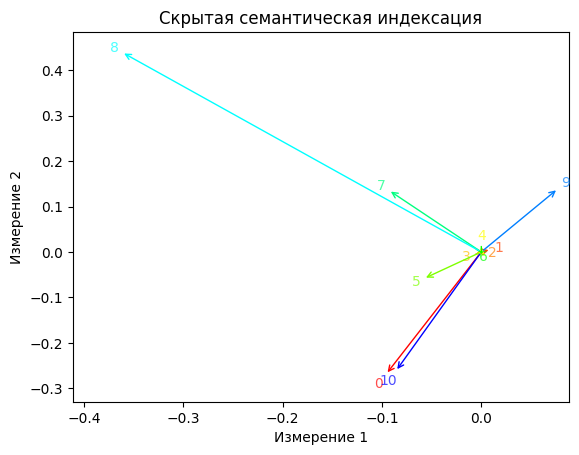

In [28]:
# Используем PSA для понижения размерности собственного вектора до 2
clf=sklearn.decomposition.PCA(n_components=2)
viz=clf.fit_transform(Vt[:num_of_dims].T)

colors=['#ff0000',
 '#ff4000',
 '#ff7f00',
 '#ffbf00',
 '#ffff00',
 '#7fff00',
 '#00ff00',
 '#00ff80',
 '#00ffff',
 '#007fff',
 '#0000ff',
 '#4500ff',]
# Для простоты мы визуализируем только первые 11 электронных писем
# Как вы можете видеть, векторы 0 и 10 практически идентичны
for i in range(11):
    plt.annotate(str(i),xy=(0,0),
                 xytext=(viz[i][0],viz[i][1]),
                arrowprops=dict(arrowstyle="<-",color=colors[i]),
                color=colors[i],alpha=0.7)

plt.title("Скрытая семантическая индексация")
plt.xlabel("Измерение 1")
plt.ylabel("Измерение 2")
plt.xlim(viz[:12,0].min()*1.1,viz[:12,0].max()*1.1)
plt.ylim(viz[:12,1].min()*1.1,viz[:12,1].max()*1.1)
plt.show()

На рисунке выше видно, что определенные слова имеют практически одинаковые вектора (т. е. близки по смыслу).

## 2.2. Пользуемся готовыми библиотеками

Рассмотрим, как подобную задачу решают современные модели NLP на более крупном наборе данных (8545 записей). Они точнее, но требуют больших вычислительных мощностей.

In [29]:
import numpy as np
import pandas as pd
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

In [30]:
try:
  url = "https://drive.google.com/uc?export=download&id=1XAa6dw1OfeW87w0PyJcT0wHkLZvjV3ds"
  output = "240310-train.csv"
  gdown.download(url, output)
  train_df = pd.read_csv("/content/"+output)
  print(train_df.head())

  url = "https://drive.google.com/uc?export=download&id=1FANdXo0TLzTrViTJp5R2-WvmJAEdhJnN"
  output = "240310-test.csv"
  gdown.download(url, output)
  test_df = pd.read_csv("/content/"+output)
  print(train_df.head())

except AttributeError:
  print("Используйте Яндекс диск https://disk.yandex.ru/d/xjAZQUw0_asZBA")
  exit()

Downloading...
From: https://drive.google.com/uc?export=download&id=1XAa6dw1OfeW87w0PyJcT0wHkLZvjV3ds
To: /content/240310-train.csv
100%|██████████| 988k/988k [00:00<00:00, 8.28MB/s]


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


Downloading...
From: https://drive.google.com/uc?export=download&id=1FANdXo0TLzTrViTJp5R2-WvmJAEdhJnN
To: /content/240310-test.csv
100%|██████████| 421k/421k [00:00<00:00, 5.19MB/s]

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [31]:
train_df=train_df.drop(['id','keyword','location'], axis=1)
train_df.head(20)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
5,#RockyFire Update => California Hwy. 20 closed...,1
6,#flood #disaster Heavy rain causes flash flood...,1
7,I'm on top of the hill and I can see a fire in...,1
8,There's an emergency evacuation happening now ...,1
9,I'm afraid that the tornado is coming to our a...,1


Давайте посмотрим на наши данные. Во-первых, пример того, что не является твитом о катастрофе...

In [32]:
train_df[train_df["target"] == 0]["text"].values[1]

'I love fruits'

... а что является

In [33]:
train_df[train_df["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

### Переводим текст в форму вектора

Теория, лежащая в основе модели, которую мы построим в этом разделе, довольно проста: слова, содержащиеся в каждом твите, являются хорошим показателем того, говорится ли в них о реальной катастрофе или нет.

Мы будем использовать CountVectorizer из scikit-learn  для подсчета слов в каждом твите и преобразования их в данные, которые может обрабатывать наша модель машинного обучения.

В данном контексте вектор — это набор чисел, с которыми может работать модель машинного обучения.

In [34]:
count_vectorizer = feature_extraction.text.CountVectorizer()

## Давайте подсчитаем количество в первых 5 твитах
example_train_vectors = count_vectorizer.fit_transform(train_df["text"][0:5])

In [35]:
## Мы здесь используем .todense(), потому что эти векторы «разрежены» (для экономии места сохраняются только ненулевые элементы)
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

(1, 54)
[[0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


Вышеприведенный массив говорит нам, что:
1. В первых пяти твитах содержится 54 уникальных слова (или токена).
2. Первый твит содержит только некоторые из этих уникальных токенов — все ненулевые значения, указанные выше, являются токенами, которые действительно существуют в первом твите.

Теперь давайте создадим векторы для всех наших твитов.

In [36]:
train_vectors = count_vectorizer.fit_transform(train_df["text"])
## Обратите внимание, что мы здесь не используем .fit_transform(). Используя только .transform(), мы гарантируем,
# что токены в векторах train являются единственными, сопоставленными тестовым векторам,
# т.е. что обучающий и тестовый векторы используют один и тот же набор токенов
test_vectors = count_vectorizer.transform(test_df["text"])

### Наша модель

Как упоминалось выше, мы считаем, что слова, содержащиеся в каждом твите, являются хорошим показателем того, о реальной катастрофе идет речь или нет. Наличие определенного слова (или набора слов) в твите может напрямую указывать на то, является ли этот твит реальным.

То, что мы предполагаем здесь, — это *линейная* связь. Итак, давайте построим линейную модель.

In [37]:
## Наши векторы действительно большие, поэтому мы хотим приблизить веса нашей модели
# к 0, не полностью сбрасывая со счетов разные слова
clf = linear_model.RidgeClassifier()

Давайте протестируем нашу модель и посмотрим, насколько хорошо она работает на обучающих данных. Для этого мы будем использовать перекрестную проверку — когда мы тренируемся на части известных данных, а затем проверяем ее на остальных. Если мы проделаем это несколько раз (с разными порциями), то сможем получить хорошее представление о том, как работает конкретная модель или метод.


In [38]:
scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=3, scoring="f1")
scores

array([0.59453669, 0.5642787 , 0.64082434])

Есть много способов потенциально улучшить показатели (например, с помощью TF IDF, LSA, LSTM / RNNs и т. д.) Но смысл работы с векторами всегда будет одинаковый.

In [39]:
from transformers import pipeline

task = "zero-shot-classification"
model = "facebook/bart-large-mnli"
text = "Чтобы построить дачный домик мне нужен кредит."
labels = ["автокредит", "ипотека", "потребительский кредит"]

classifier = pipeline(task, model)
result = classifier(text, labels)

print(result["labels"][0],"\n",result["scores"][0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

потребительский кредит 
 0.5612237453460693


## Задание 1. Классификация текста

Наша задача — запустить 2 модели на [упомянутом отчете ПАО «Аэрофлот»](https://ir.aeroflot.ru/fileadmin/Otchet_ehmitenta_za_6_mesjacev_2023.pdf). Используя их, ответьте на вопрос:

* На странице 19 указан пункт 1.9.3. 	«Финансовые риски». К какой группе относятся эти риски ?

Чтобы решить эту задачу, рассмотрим [репозиторий готовых моделей Huggingface](https://huggingface.co/models?pipeline_tag=text-classification). Он ведется крупным сообществом разработчиков, а модели снабжены первоклассно разработанной документацией.

Ознакомьтесь с разделом Models (Модели). В зависимости от уровня сложности задания вам будет предложена модель для классификации текста `RussianNLP/ruRoBERTa-large-rucola` или `microsoft/Multilingual-MiniLM-L12-H384` или `openai-community/roberta-large-openai-detector`.

In [10]:
student_topic_choice = 3

In [11]:
# Этот код напечатает задание №1 внизу
description = ["""Вам необходимо использовать модель [RussianNLP/ruRoBERTa-large-rucola](https://huggingface.co/RussianNLP/ruRoBERTa-large-rucola).""",
"""Вам необходимо использовать модель [microsoft/Multilingual-MiniLM-L12-H384](https://huggingface.co/microsoft/Multilingual-MiniLM-L12-H384).""",
"""Вам необходимо использовать модель [openai-community/roberta-large-openai-detector](https://huggingface.co/openai-community/roberta-large-openai-detector)."""]
display(Markdown(f"""{description[student_topic_choice-1]}"""))

Вам необходимо использовать модель [openai-community/roberta-large-openai-detector](https://huggingface.co/openai-community/roberta-large-openai-detector).

In [12]:
# Поиск строки в тексте
for i in range(1000000):
  if "1.9.4. Правовые риски" in clean_emitent_report[i:i+30]:
    print(i)

3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
68642
68643
68644
68645
68646
68647
68648
68649
68650
68651


In [ ]:
def task1():

  text = clean_emitent_report[63251:64124]
  print(text)
  # Введите ваш код сюда
  result = None

  #result = classifier ........

  #print(result["labels"][0])
  #print(result["scores"][0])
  # Введите ваш код сюда

  return {"labels":result["labels"][0],
          "scores":result["scores"][0]
          }
task1()

1.9.3. Финансовые риски   Основными финансовыми рисками ПАО «Аэрофлот» являются:     Кредитные риски;    Рыночные риски.   Компания  непрерывно  анализирует  и  повышает  эффективность  системы  управления  финансовыми  рисками  через  анализ  внутренних  бизнес-процессов,  пересмотр  и  актуализацию  внутренних нормативных документов в соответствии с изменившимися рыночными условиями  и лучшей международной практикой управления рисками.   Также компания проводит непрерывную автоматизацию отдельных процессов оценки и  управления  финансовыми  рисками,  с  целью  более  оперативного  реагирования  на  риск  и      19    минимизации ошибок, вызванных "человеческим фактором".   Основным  источником  кредитных  рисков  являются  контрагенты  авиакомпании,  осуществляющие продажу пассажирских и грузовых перевозок от имени компании, а также иные  контрагенты,  кото


Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'sequence': 'Чтобы построить дачный домик мне нужен кредит.', 'labels': ['потребительский кредит', 'ипотека', 'автокредит'], 'scores': [0.37021660804748535, 0.32733166217803955, 0.3024517297744751]}


{'labels': 'потребительский кредит', 'scores': 0.37021660804748535}

In [13]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Загрузка модели и токенизатора
tokenizer = RobertaTokenizer.from_pretrained('openai-community/roberta-large-openai-detector')
model = RobertaForSequenceClassification.from_pretrained('openai-community/roberta-large-openai-detector')

def task1():
    # Текст для классификации из отчета
    text = clean_emitent_report[63251:64124]
    print(text)

    # Токенизация текста
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Классификация текста
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()
    predicted_label = model.config.id2label[predicted_class_id]

    result = {
        "labels": predicted_label,
        "scores": torch.softmax(logits, dim=1).max().item()
    }

    print(result["labels"])
    print(result["scores"])

    return result

# Вызов функции
task1_result = task1()
print(task1_result)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/519 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at openai-community/roberta-large-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


1.9.3. Финансовые риски   Основными финансовыми рисками ПАО «Аэрофлот» являются:     Кредитные риски;    Рыночные риски.   Компания  непрерывно  анализирует  и  повышает  эффективность  системы  управления  финансовыми  рисками  через  анализ  внутренних  бизнес-процессов,  пересмотр  и  актуализацию  внутренних нормативных документов в соответствии с изменившимися рыночными условиями  и лучшей международной практикой управления рисками.   Также компания проводит непрерывную автоматизацию отдельных процессов оценки и  управления  финансовыми  рисками,  с  целью  более  оперативного  реагирования  на  риск  и      19    минимизации ошибок, вызванных "человеческим фактором".   Основным  источником  кредитных  рисков  являются  контрагенты  авиакомпании,  осуществляющие продажу пассажирских и грузовых перевозок от имени компании, а также иные  контрагенты,  кото
LABEL_1
0.8058621287345886
{'labels': 'LABEL_1', 'scores': 0.8058621287345886}


# Анализ настроений

Классический способ решения задачи — разработка нескольких моделей, сведение результатов их работы в табличку, выбор лучшей и отправка ее на оптимизацию методом GridSearch (поиск по сетке параметров).

Ниже пример того, как решается задача анализа настроений на наборе данных IMDB из 50000 рецензий. Он содержит 2 столбца (обзор и настроение), которые помогут нам определить, является ли отзыв положительным или отрицательным.

**Формулировка задачи:** найти, какая модель машинного обучения лучше всего подходит для прогнозирования настроений (выходных данных) на основе обзора фильма (входных данных).

В задании, которое предлагаем вам решить, нужно будет подобным образом проанализировать другой датасет.

## Пример решения задачи анализа настроений

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Downloading...
From: https://drive.google.com/uc?export=download&id=1TP5cxcndhJ58_7dqcTRi7bN9BjFWtaQ4
To: /content/imdb-dataset-of-50k-movie-reviews.csv
100%|██████████| 66.5M/66.5M [00:01<00:00, 48.4MB/s]


   Unnamed: 0                                             review sentiment
0           0  One of the other reviewers has mentioned that ...  positive
1           1  A wonderful little production. <br /><br />The...  positive
2           2  I thought this was a wonderful way to spend ti...  positive
3           3  Basically there's a family where a little boy ...  negative
4           4  Petter Mattei's "Love in the Time of Money" is...  positive


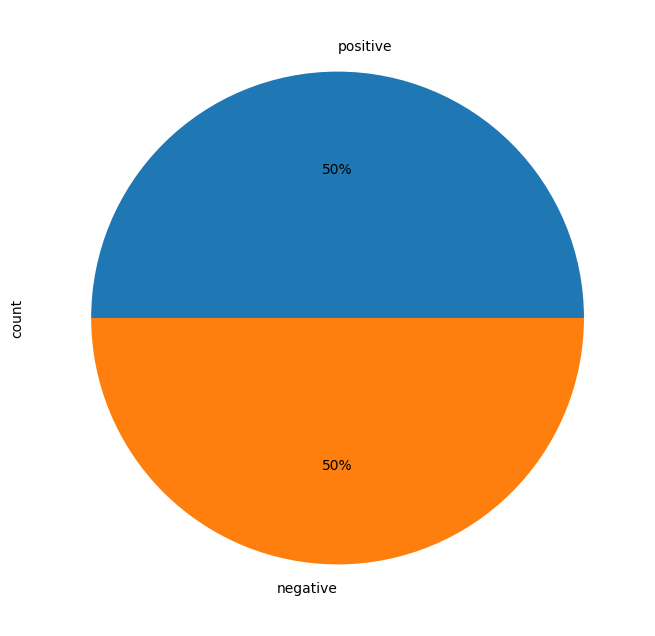

In [14]:
import numpy as np
import re
import nltk
import pandas as pd
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline
try:
  url = "https://drive.google.com/uc?export=download&id=1TP5cxcndhJ58_7dqcTRi7bN9BjFWtaQ4"
  output = "imdb-dataset-of-50k-movie-reviews.csv"
  gdown.download(url, output)
  imdb_reviews = pd.read_csv("/content/"+output)
  print(imdb_reviews.head())

except AttributeError:
  print("Используйте Яндекс диск https://disk.yandex.ru/d/xjAZQUw0_asZBA")
  exit()

plt.rcParams["figure.figsize"] = [10, 8]
imdb_reviews.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%')

reviews = imdb_reviews["review"].tolist()
labels = imdb_reviews["sentiment"].values

processed_reviews = []

for text in range(0, len(reviews)):
        text = re.sub(r'\W', ' ', str(reviews[text]))
        text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
        text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
        text = re.sub(r'\s+', ' ', text, flags=re.I)
        text = re.sub(r'^b\s+', '', text)
        processed_reviews.append(text)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(processed_reviews, labels, test_size=0.2, random_state=0)

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.75, stop_words=stopwords.words('english'))
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()


### Грубый подбор модели

В нашем примере входные данные (review) и выходные данные (sentiment) четко определены, поэтому мы можем сказать, что имеем дело с обучением с учителем. Мы сравним 5 моделей.

###  Случайный лес

In [46]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200, random_state=42)
rfc.fit(X_train[:10000], y_train[:10000])
y_pred = rfc.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[4271  764]
 [ 884 4081]]
              precision    recall  f1-score   support

    negative       0.83      0.85      0.84      5035
    positive       0.84      0.82      0.83      4965

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

0.8352



###  Метод опорных векторов (SVM)


In [47]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')
svc.fit(X_train[:10000], y_train[:10000])

SVC(kernel='linear')

In [48]:
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[4329  706]
 [ 693 4272]]
              precision    recall  f1-score   support

    negative       0.86      0.86      0.86      5035
    positive       0.86      0.86      0.86      4965

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

0.8601



### Решающее дерево


In [49]:
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train[:10000], y_train[:10000])

DecisionTreeClassifier()

In [50]:
y_pred = dec_tree.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[3543 1492]
 [1541 3424]]
              precision    recall  f1-score   support

    negative       0.70      0.70      0.70      5035
    positive       0.70      0.69      0.69      4965

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000

0.6967



### Логистическая регрессия


In [51]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train[:10000], y_train[:10000])

LogisticRegression()

In [52]:
y_pred = log_reg.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[4326  709]
 [ 653 4312]]
              precision    recall  f1-score   support

    negative       0.87      0.86      0.86      5035
    positive       0.86      0.87      0.86      4965

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

0.8638


### Сравним точность предсказания моделей, обученных на конкретном наборе данных

In [53]:
reviews_arr = ['A good movie','I did not like this movie at all I gave this movie away','An excellent movie']
for a_review in reviews_arr:
  print(log_reg.predict(vectorizer.transform([a_review])))

['positive']
['negative']
['positive']


In [54]:
print("rfc",rfc.score(X_test, y_test))
print("dec_tree",dec_tree.score(X_test, y_test))
print("svc",svc.score(X_test, y_test))
print("log_reg",log_reg.score(X_test, y_test))

rfc 0.8352
dec_tree 0.6967
svc 0.8601
log_reg 0.8638


SVM и логистическая регрессия работают лучше, чем два других классификатора. Причем SVM имеет небольшое преимущество (84% точности). Таким образом, мы сосредоточимся только на SVM.

### Точная настройка модели методом GridSearchCV

Метод поиска параметров по сетке (GridSearch) проводит исчерпывающий поиск по заданным параметрам с целью получения оптимальных значений гиперпараметров.

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {'C': [1,4,8,16,32], 'kernel' : ['linear','rbf']}
svc = SVC()
svc_grid = GridSearchCV(svc,params, cv = 5)
svc_grid.fit(X_train, y_train)

In [ ]:
print(svc_grid.best_params_)
print(svc_grid.best_estimator_)

Таким образом, можно сказать, что полученные выше параметры и ядро являются **наилучшими** для нашей модели, и будут давать максимально точные результаты.

### Анализ настроений с помощью предобученной нейросети

In [ ]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
sentiment_pipeline(reviews_arr)

Обратите внимание на точность модели (и на количество строк кода).

## Задание 2. Анализ настроений

In [15]:
# Этот код напечатает задание №2 внизу
description = ["""Вам необходимо выбрать модель [https://huggingface.co/cointegrated/rubert-tiny-toxicity](https://huggingface.co/cointegrated/rubert-tiny-toxicity) и написать код анализа настроений для 100 рецензий с индексами с 1001 по 1100.""",
"""Вам необходимо выбрать любую модель [из репозитория](https://huggingface.co/models?pipeline_tag=text-classification&sort=downloads&search=sentiment) и написать код анализа настроений для 100 рецензий с индексами с 1001 по 1100.""",
"""Нужно подключить [модель](https://huggingface.co/s-nlp/russian_toxicity_classifier) для анализа тональности высказываний (нейтральное/токсичное)."""]
display(Markdown(f"""{description[student_topic_choice-1]}"""))

Нужно подключить [модель](https://huggingface.co/s-nlp/russian_toxicity_classifier) для анализа тональности высказываний (нейтральное/токсичное).

In [ ]:
def task2():
  # Длина строки не должна превышать 512 символов
  reviews_arr = [short_string[:512] for short_string in reviews[1001:1100]]
  # Введите ваш код сюда
  result = None


  # Введите ваш код сюда

  return {"label":result[50]["label"],
          "score":result[50]["score"]
          }
task2()

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Загрузка модели и токенизатора
tokenizer = AutoTokenizer.from_pretrained('s-nlp/russian_toxicity_classifier')
model = AutoModelForSequenceClassification.from_pretrained('s-nlp/russian_toxicity_classifier')

def task2():

    # Длина строки не должна превышать 512 символов
    reviews_arr = [short_string[:512] for short_string in reviews[1001:1100]]

    # Токенизация текстов
    inputs = tokenizer(reviews_arr, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Анализ тональности
    outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.softmax(logits, dim=1)

    # Извлечение меток и оценок
    labels = predictions.argmax(dim=1).tolist()
    scores = predictions.max(dim=1).values.tolist()

    result = [{"label": labels[i], "score": scores[i]} for i in range(len(labels))]

    return {"label": result[50]["label"], "score": result[50]["score"]}

# Вызов функции
task2_result = task2()
print(task2_result)


tokenizer_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

# Ответы на вопросы

[Код](https://huggingface.co/cointegrated/rut5-base-multitask), отвечающий на вопросы, ищет частотные слова и уже по ним строит ответ.

In [ ]:
!pip install transformers sentencepiece -q
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer


context = clean_emitent_report[63251:64124]
print(context)

question = "Какие есть риски ?"

tokenizer = T5Tokenizer.from_pretrained("cointegrated/rut5-base-multitask")
model = T5ForConditionalGeneration.from_pretrained("cointegrated/rut5-base-multitask")

def generate(text, **kwargs):
    inputs = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        hypotheses = model.generate(**inputs, num_beams=25, **kwargs)
    return tokenizer.decode(hypotheses[0], skip_special_tokens=True)


print(generate(f'comprehend | {context}. Вопрос: {question}'))



1.9.3. Финансовые риски   Основными финансовыми рисками ПАО «Аэрофлот» являются:     Кредитные риски;    Рыночные риски.   Компания  непрерывно  анализирует  и  повышает  эффективность  системы  управления  финансовыми  рисками  через  анализ  внутренних  бизнес-процессов,  пересмотр  и  актуализацию  внутренних нормативных документов в соответствии с изменившимися рыночными условиями  и лучшей международной практикой управления рисками.   Также компания проводит непрерывную автоматизацию отдельных процессов оценки и  управления  финансовыми  рисками,  с  целью  более  оперативного  реагирования  на  риск  и      19    минимизации ошибок, вызванных "человеческим фактором".   Основным  источником  кредитных  рисков  являются  контрагенты  авиакомпании,  осуществляющие продажу пассажирских и грузовых перевозок от имени компании, а также иные  контрагенты,  кото


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/828k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/977M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Рыночные риски


## Задание 3. Ответы на вопросы

In [ ]:
# Этот код напечатает задание №3 внизу
description = ["""Вам необходимо выбрать текстовый отрывок [со страницы 21 отчета](https://ir.aeroflot.ru/fileadmin/Otchet_ehmitenta_za_6_mesjacev_2023.pdf) и получить от многозадачной языковой [модели](https://huggingface.co/cointegrated/rut5-base-multitask) ответ на вопрос:
""",
"""Вам необходимо выбрать текстовый отрывок [со страницы 50 отчета](https://ir.aeroflot.ru/fileadmin/Otchet_ehmitenta_za_6_mesjacev_2023.pdf) и получить от многозадачной языковой [модели](https://huggingface.co/cointegrated/rut5-base-multitask) ответ на вопрос:""",
"""Вам необходимо выбрать текстовый отрывок [со страницы 40 отчета](https://ir.aeroflot.ru/fileadmin/Otchet_ehmitenta_za_6_mesjacev_2023.pdf) и получить от многозадачной языковой [модели](https://huggingface.co/cointegrated/rut5-base-multitask) ответ на вопрос:"""]
questions = ["Есть ли инфляционные риски?","Сколько у эмитента акционеров?","Кто входит в состав ревизионной комиссии?"]
selected_question = questions[student_topic_choice-1]
display(Markdown(f"""{description[student_topic_choice-1]}

* {selected_question}
"""))


Вам необходимо выбрать текстовый отрывок [со страницы 21 отчета](https://ir.aeroflot.ru/fileadmin/Otchet_ehmitenta_za_6_mesjacev_2023.pdf) и получить от многозадачной языковой [модели](https://huggingface.co/cointegrated/rut5-base-multitask) ответ на вопрос:


* Есть ли инфляционные риски?


In [ ]:
def task3():
    context = clean_emitent_report[67844:68794]
    print(context)
    # Введите ваш код сюда
    result = None

    # Введите ваш код сюда

    return {"result":result  }
task3()

## Обобщение содержания документа

Изложение краткого содержания документов — это процесс «выжимки» данных по наиболее важным словам.

In [ ]:
context = clean_emitent_report[68692:68994]
print(context)
context="""Исходя из установленного критерия существенности (размер требований 10 или более
процентов балансовой стоимости активов Общества на дату окончания последнего завершенного
отчетного периода), в АО «Авиакомпания «Россия» и ООО «Авиакомпания «Победа»
отсутствуют риски, связанные с текущими судебными и/или административными процессами,
а также риски, связанные с изменением действующего законодательства.
По состоянию на 30.06.2023 отсутствуют риски, связанные с текущими судебными делами,
в которых участвует АО «Авиакомпания «Россия» и ООО «Авиакомпания «Победа», которые
могут оказать существенное негативное влияние на результаты финансово-хозяйственной
деятельности Общества или Группы Аэрофлот в целом.
Информация не раскрывается и (или) не предоставляется на основании Постановления
Правительства РФ от 04.07.2023 № 1102 «Об особенностях раскрытия и (или) предоставления
информации, подлежащей раскрытию и (или) предоставлению в соответствии с требованиями
Федерального закона «Об акционерных обществах» и Федерального закона «О рынке ценных
бумаг» в связи с тем, что в отношении ПАО «Аэрофлот» действуют ограничительные меры."""

овленного  критерия  существенности  (размер  требований  10  или  более  процентов балансовой стоимости активов Общества на дату окончания последнего завершенного  отчетного  периода),  в  АО  «Авиакомпания  «Россия»  и  ООО  «Авиакомпания  «Победа»  отсутствуют  риски,  связанные  с  текущими  судеб


In [ ]:
print(generate(f'headline | {context}', max_length=32))

В АО «Авиакомпания «Россия» и ООО «Авиакомпания «Победа» отсутствуют риски, связанные с текущими судебными и/или административными процессами


## Задание 4. Обобщение содержания документа

In [ ]:
# Этот код напечатает задание №4 внизу
general = """Для создания краткого резюме (или, как иногда называют, для суммаризации) вам необходимо выбрать небольшой текстовый отрывок из отчета ПАО «Аэрофлот» и получить от многозадачной языковой [модели](https://huggingface.co/cointegrated/rut5-base-multitask) краткое содержание """
description = [general+"(не более 90 символов).",general+"(не более 70 символов).",general+"(не более 50 символов)."]
display(Markdown(f"""{description[student_topic_choice-1]}"""))

Для создания краткого резюме (или, как иногда называют, для суммаризации) вам необходимо выбрать небольшой текстовый отрывок из отчета ПАО «Аэрофлот» и получить от многозадачной языковой [модели](https://huggingface.co/cointegrated/rut5-base-multitask) краткое содержание (не более 90 символов).

In [ ]:
def task4():
    context = clean_emitent_report[68692:68994]
    print(context)
    # Введите ваш код сюда
    result = None

    # Введите ваш код сюда

    return {"result":result  }
task4()

овленного  критерия  существенности  (размер  требований  10  или  более  процентов балансовой стоимости активов Общества на дату окончания последнего завершенного  отчетного  периода),  в  АО  «Авиакомпания  «Россия»  и  ООО  «Авиакомпания  «Победа»  отсутствуют  риски,  связанные  с  текущими  судеб


{'result': None}

## Задание 5. Сравнение работы моделей ML и DL для задач NLP

Вы использовали модели классического машинного обучения (ML) и глубокие языковые модели (DL) — трансформеры для обработки текстовых данных. Проанализируйте сильные и слабые стороны моделей ML и DL.

За это задание можно получить максимум 4 балла, по одном баллу за полный и непротиворечивый ответ:

* о сильных сторонах ML;
* слабых сторонах ML;
* сильных сторонах DL;
* слабых сторонах DL.

In [ ]:
import ipywidgets as widgets
conclusion = widgets.Textarea(
    value='',
    placeholder="""
    Сильные стороны моделей ML
    Слабые стороны моделей ML
    Сильные стороны моделей DL
    Слабые стороны моделей DL
    """,
    description='Ваш ответ',
    disabled=False
    )
conclusion



Textarea(value='', description='Ваш ответ', placeholder='\n    Сильные стороны моделей ML\n    Слабые стороны …

In [ ]:
def task5():
    print(conclusion.value)
    return {"conclusion":conclusion.value  }
task5()

{'conclusion': ''}

### Выводы

Мы можем использовать легкие и быстрые модели ML с определенной точностью. Либо остановить свой выбор на более точных моделях DL, осознавая необходимость тщательной предобработки данных и длительного времени инференса.

## Отметка о выполнении задания

In [ ]:
%%capture
def send_submission_attempt(b):
  result = requests.post(str('https://autotest-egister.amvera.io/submission_attempt/'),
  data=json.dumps({
      "start":str(start),
      "task1":str(json.dumps(task1()))[:100],
      "task2":str(json.dumps(task2()))[:100],
      "task3":str(json.dumps(task3()))[:100],
      "task4":str(json.dumps(task4()))[:100],
      "task5":str(json.dumps(task5()))[:100],
      "id":get_hashed_email()+":"+nb_name,
      "stop":str(time.time()),
      "duration":str(time.time()-start),
      "homework":4
  })).text
  display(Markdown(f"Результат отправки {result} {datetime.datetime.now().isoformat()}"))
button = Button(description='Отправить')
button.on_click(send_submission_attempt)

In [ ]:
checkbox = widgets.Checkbox(value=False, description='подтверждаю')
display(Markdown("Я закончил(а) работу с заданиями. Эту работу я выполнил(а) самостоятельно."),checkbox,button)

Я закончил(а) работу с заданиями. Эту работу я выполнил(а) самостоятельно.

Checkbox(value=False, description='подтверждаю')

Button(description='Отправить', style=ButtonStyle())

## Задание на дополнительный балл

Автоматическая генерация текста с использованием обратной связи от человека (RLHF) или другой модели (RLAIF) является одним из самых передовых направлений в обучении больших языковых моделей.

Попытайтесь изучить [доклад](https://arxiv.org/pdf/1909.08593.pdf) и написать [код](https://github.com/openai/lm-human-preferences) для моделей класса [GPT](https://github.com/huggingface/trl).

In [ ]:
!pip install trl -q
import torch
from transformers import AutoTokenizer
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead, create_reference_model
from trl.core import respond_to_batch

# Подгружаем трансформер
model = AutoModelForCausalLMWithValueHead.from_pretrained('gpt2')
model_ref = create_reference_model(model)
tokenizer = AutoTokenizer.from_pretrained('gpt2')

# Инициализируем конфиг RL
ppo_config = PPOConfig(batch_size=1,)

# Токенизируем запрос
query_txt = "This morning I went to the "
query_tensor = tokenizer.encode(query_txt, return_tensors="pt")

# Получаем ответ модели
response_tensor  = respond_to_batch(model, query_tensor)

# Создаем ppo trainer
ppo_trainer = PPOTrainer(ppo_config, model, model_ref, tokenizer)

# Определяем вознаграждение за ответ
# (это может быть любая награда, такая как обратная связь от человека или выходные данные другой модели)
reward = [torch.tensor(1.0)]


# Обучаем модель за один шаг с помощью ppo
train_stats = ppo_trainer.step([query_tensor[0]], [response_tensor[0]], reward)
train_stats